In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import typing as tp
import yaml
import random
import os
import sys
import soundfile as sf
import librosa
import librosa.display
import cv2
import matplotlib.pyplot as plt
import time
import pickle
import glob
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
# import resnest.torch as resnest_torch

from torchvision import models

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
# from resnet import ResNet, Bottleneck

from albumentations.core.transforms_interface import DualTransform, BasicTransform
import albumentations as albu

pd.options.display.max_rows = 500
pd.options.display.max_columns = 500

In [2]:
INPUT_ROOT = Path("/home/knikaido/work/Rainforest-Connection/data")
RAW_DATA = INPUT_ROOT / "rfcx-species-audio-detection"
TRAIN_AUDIO_DIR = RAW_DATA / "train"
# TRAIN_RESAMPLED_AUDIO_DIRS = [
#   INPUT_ROOT / "birdsong-resampled-train-audio-{:0>2}".format(i)  for i in range(5)
# ]
TEST_AUDIO_DIR = RAW_DATA / "test"
FEAT_DIR =  '/home/knikaido/work/Rainforest-Connection/Git/feature/05/'
TRAIN_PRED_DIR = '/home/knikaido/work/Rainforest-Connection/Git/33/output/train_pred/'
PERIOD = 5.0

In [3]:
pred_pathes = sorted(glob.glob(TRAIN_PRED_DIR + '*.npy'))
len(pred_pathes)

4727

In [4]:
index = 12
train_pred = np.load(pred_pathes[index])
pred_pathes[index]

'/home/knikaido/work/Rainforest-Connection/Git/33/output/train_pred/009b760e6.npy'

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


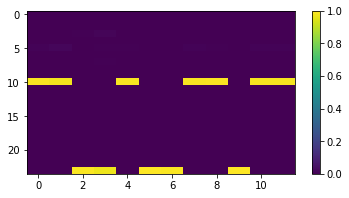

In [5]:
fig = plt.figure(figsize=(6,3))
im = plt.imshow(train_pred.T, vmin=0, vmax=1)
plt.axes().set_aspect('auto')
# plt.xticks(np.arange(train_pred.T.shape[1])*5)
fig.colorbar(im)
# plt.legend()

In [6]:
th = 0.99
tmin = []
species = []
wavnames = []

for path in tqdm(pred_pathes):
    train_pred = np.load(path)
    for i in range(train_pred.shape[0]):
        start = i * PERIOD
        end = start + PERIOD
        if np.max(train_pred[i]) > th:
            species.append(np.argmax(train_pred[i]))
            tmin.append(start)
            wavnames.append(path.split('/')[-1][:-4])

100%|██████████| 4727/4727 [00:01<00:00, 3785.26it/s]


In [7]:
train_tp_custom = pd.DataFrame()

In [8]:
train_tp_custom['recording_id'] = wavnames
train_tp_custom['species_id'] = species
train_tp_custom['songtype_id'] = 0
train_tp_custom['t_min'] = tmin
train_tp_custom['f_min'] = 0
train_tp_custom['t_max'] = np.array(tmin) + 5
train_tp_custom['f_max'] = 0

In [9]:
train_tp_custom

,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max
0,006ab765f,23,0,35.0,0,40.0,0
1,006ab765f,23,0,40.0,0,45.0,0
2,006ab765f,23,0,45.0,0,50.0,0
3,006ab765f,23,0,50.0,0,55.0,0
4,006ab765f,23,0,55.0,0,60.0,0
...,...,...,...,...,...,...,...
8367,ffd88cd84,15,0,0.0,0,5.0,0
8368,ffd88cd84,15,0,5.0,0,10.0,0
8369,ffd88cd84,15,0,10.0,0,15.0,0
8370,ffd88cd84,15,0,15.0,0,20.0,0


In [10]:
train = pd.read_csv(RAW_DATA / "train_tp.csv")
train

,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max
0,003bec244,14,1,44.5440,2531.250,45.1307,5531.25
1,006ab765f,23,1,39.9615,7235.160,46.0452,11283.40
2,007f87ba2,12,1,39.1360,562.500,42.2720,3281.25
3,0099c367b,17,4,51.4206,1464.260,55.1996,4565.04
4,009b760e6,10,1,50.0854,947.461,52.5293,10852.70
...,...,...,...,...,...,...,...
1211,fe8d9ac40,13,1,53.4720,93.750,54.0960,843.75
1212,fea6b438a,4,1,43.5787,2531.250,45.7653,4031.25
1213,ff2eb9ce5,0,1,15.2267,5906.250,16.0213,8250.00
1214,ffb8d8391,5,1,14.3467,4781.250,16.6987,10406.20


In [11]:
for ids in tqdm(train['recording_id'].values):
    train_tp_custom = train_tp_custom[train_tp_custom['recording_id']!=ids]
    train_tp_custom.reset_index(drop=True, inplace=True)

100%|██████████| 1216/1216 [00:00<00:00, 1375.30it/s]


In [12]:
train_tp_custom

,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max
0,0072f0839,12,0,50.0,0,55.0,0
1,009fbc7b4,14,0,0.0,0,5.0,0
2,009fbc7b4,14,0,5.0,0,10.0,0
3,009fbc7b4,14,0,10.0,0,15.0,0
4,009fbc7b4,14,0,15.0,0,20.0,0
...,...,...,...,...,...,...,...
5225,ffd88cd84,15,0,0.0,0,5.0,0
5226,ffd88cd84,15,0,5.0,0,10.0,0
5227,ffd88cd84,15,0,10.0,0,15.0,0
5228,ffd88cd84,15,0,15.0,0,20.0,0


In [13]:
train_tp_custom.to_csv(RAW_DATA / 'train_tp_custom.csv', index=False)

In [33]:
train_merge = pd.concat([train_tp_custom, train])
train_merge.sort_values('recording_id', inplace=True)
train_merge.reset_index(drop=True, inplace=True)
train_merge

,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max
0,003bec244,14,1,44.5440,2531.25,45.1307,5531.25
1,006ab765f,23,1,39.9615,7235.16,46.0452,11283.40
2,0072f0839,12,0,50.0000,0.00,55.0000,0.00
3,007f87ba2,12,1,39.1360,562.50,42.2720,3281.25
4,0099c367b,17,4,51.4206,1464.26,55.1996,4565.04
...,...,...,...,...,...,...,...
6441,ffd88cd84,15,0,0.0000,0.00,5.0000,0.00
6442,ffd88cd84,15,0,5.0000,0.00,10.0000,0.00
6443,ffd88cd84,15,0,10.0000,0.00,15.0000,0.00
6444,ffd88cd84,15,0,15.0000,0.00,20.0000,0.00


In [35]:
train_merge.to_csv(RAW_DATA / 'train_tp_custom.csv', index=False)